# Time Series Wave Height and Wave Period

Wave energy is highly correlated with wave height and with wave period as seen in EDA, with linear regression. Since Wave Energy would not be an available feature directly from live buoy data, it was decided to try to forecast wave height and wave period seperately. This may be more useful in live forecasting and Wave Energy can be derived or estimated from wave height and wave period. 

## Data 
The daily imputed data will be used, containing all features expect for stn_id and Q_Flag.
<details>
  <summary>Data Dictionary</summary>
  
| Field       | Description                                             |
|-------------|---------------------------------------------------------|
| Index       | Date time excluding minutes (used to join df_buoy and df_hind) |
| STN_ID      | Buoy station ID                                         |
| Datetime_x  | Datetime from df_buoy                                  |
| DEPTH       | Depth in meters                                        |
| VWH         | Characteristic significant wave height (reported by the buoy) (m) |
| VCMX        | Maximum zero crossing wave height (reported by the buoy) (m) |
| VTP         | Wave spectrum peak period (reported by the buoy) (s)   |
| WDIR        | Direction from which the wind is blowing (° True)      |
| WSPD        | Horizontal wind speed (m/s)                            |
| WSS         | Horizontal scalar wind speed (m/s)                     |
| GSPD        | Gust wind speed (m/s)                                   |
| ATMS        | Atmospheric pressure at sea level (mbar)               |
| DRYT        | Dry bulb temperature (air temperature) (°C)            |
| SSTP        | Sea surface temperature (°C)                           |
| Q_FLAG      | Quality control flag                                   |
| Datetime_y  | Date time in 3-hour intervals from df_hind             |
| WD          | Wind Direction (deg from which wind is blowing (° True)) |
| WS          | Wind Speed (m/s)                                       |
| ETOT        | Total Variance of Total Spectrum (m^2)                |
| TP          | Peak Spectral Period of Total Spectrum (sec)           |
| VMD         | Vector Mean Direction of Total Spectrum (deg to which) |
| ETTSea      | Total Variance of Primary Partition (m^2)             |
| TPSea       | Peak Spectral Period of Primary Partition (sec)        |
| VMDSea      | Vector Mean Direction of Primary Partition (deg to which) |
| ETTSw       | Total Variance of Secondary Partition (m^2)           |
| TPSw        | Peak Spectral Period of Secondary Partition (sec)      |
| VMDSw       | Vector Mean Direction of Secondary Partition (deg to which) |
| MO1         | First Spectral Moment of Total Spectrum (m^2/s)       |
| MO2         | Second Spectral Moment of Total Spectrum (m^2/s^2)    |
| HS          | Significant Wave Height (m)                            |
| DMDIR       | Dominant Direction (deg to which)                       |
| ANGSPR      | Angular Spreading Function                             |
| INLINE      | In-Line Variance Ratio                                 |

<details>

In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import pmdarima as pm

import statsmodels.api as sm
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import month_plot
import itertools
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

import plotly.graph_objects as go
import plotly.express as px

from sklearn.metrics import mean_squared_error, mean_absolute_error
import plotly.express as px


In [22]:
#import data 
df=pd.read_csv('../Data/df_daily_imputed.csv', index_col=0)

In [23]:
df.head()

LATITUDE  LONGITUDE  DEPTH      VWH$       VCMX       VTP$  \
Datetime_buoy                                                               
1988-11-22        48.83      126.0   73.0  5.420000   8.400000  11.640000   
1988-11-23        48.83      126.0   73.0  6.657391  11.591304  14.960000   
1988-11-24        48.83      126.0   73.0  4.434286   7.861905  15.097143   
1988-11-25        48.83      126.0   73.0  3.676087   6.047826  13.973913   
1988-11-26        48.83      126.0   73.0  3.114091   5.440909  11.930909   

                     WDIR       WSPD       GSPD      WDIR.1  ...     VMDSea  \
Datetime_buoy                                                ...              
1988-11-22     234.000000  11.800000  15.600000  225.000000  ...  32.200000   
1988-11-23     265.695652   7.491304  10.630435  256.086957  ...  21.869565   
1988-11-24     187.095238   6.809524   9.252381  177.619048  ...  68.300000   
1988-11-25     200.956522   6.026087   8.152174  191.739130  ...  44.073913   
1988-11-26     236.500000   5.613636   7.395455  227.227273  ...  79.350000   

                  ETTSw       TPSw      VMDSw       MO1       MO2        HS  \
Datetime_buoy                                                                 
1988-11-22     0.844000  12.229000  63.700000  0.682000  0.564000  3.981000   
1988-11-23     0.661391  13.783913  76.808696  1.459913  1.249043  5.604522   
1988-11-24     1.774143  14.318143  75.528571  2.440857  1.881714  7.755571   
1988-11-25     1.157522  14.076913  88.278261  0.799304  0.618565  4.529000   
1988-11-26     0.711591  13.506682  76.372727  0.769818  0.690773  4.112773   

                   DMDIR    ANGSPR    INLINE  
Datetime_buoy                                 
1988-11-22     67.000000  0.807500  0.715300  
1988-11-23     52.469565  0.771422  0.673013  
1988-11-24     75.142857  0.850457  0.765200  
1988-11-25     87.786957  0.859587  0.789322  
1988-11-26     89.922727  0.819845  0.757150  

[5 rows x 33 columns]

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9902 entries, 1988-11-22 to 2016-01-01
Data columns (total 33 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LATITUDE   9902 non-null   float64
 1   LONGITUDE  9902 non-null   float64
 2   DEPTH      9902 non-null   float64
 3   VWH$       9902 non-null   float64
 4   VCMX       9902 non-null   float64
 5   VTP$       9902 non-null   float64
 6   WDIR       9902 non-null   float64
 7   WSPD       9902 non-null   float64
 8   GSPD       9902 non-null   float64
 9   WDIR.1     9902 non-null   float64
 10  WSPD.1     9902 non-null   float64
 11  GSPD.1     9902 non-null   float64
 12  ATMS       9902 non-null   float64
 13  DRYT       9902 non-null   float64
 14  SSTP       9902 non-null   float64
 15  YEAR       9902 non-null   float64
 16  WD         9902 non-null   float64
 17  WS         9902 non-null   float64
 18  ETOT       9902 non-null   float64
 19  TP         9902 non-null   float64
 20

In [25]:
wave_period_data = df[['VTP$']].copy()

In [26]:
wave_height_data =df[['VWH$']].copy()

Text(0.5, 1.0, 'Wave Height(m) over Time')

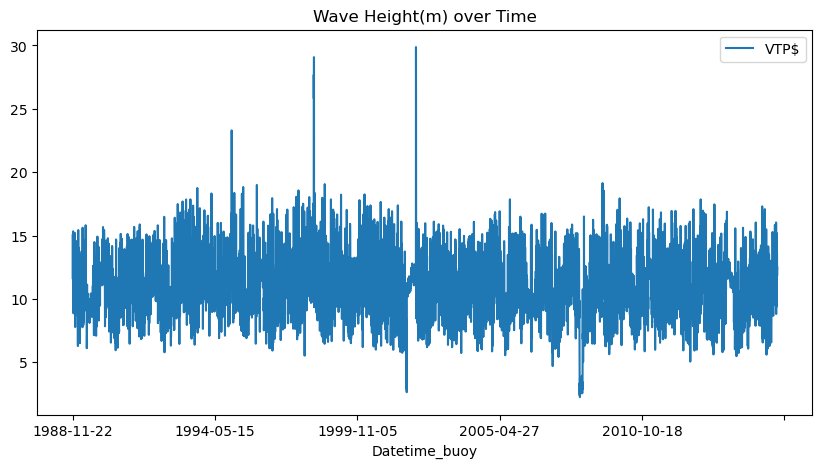

In [27]:

wave_period_data.plot(figsize=(10,5))
plt.title('Wave Height(m) over Time')

<Axes: xlabel='Datetime_buoy'>

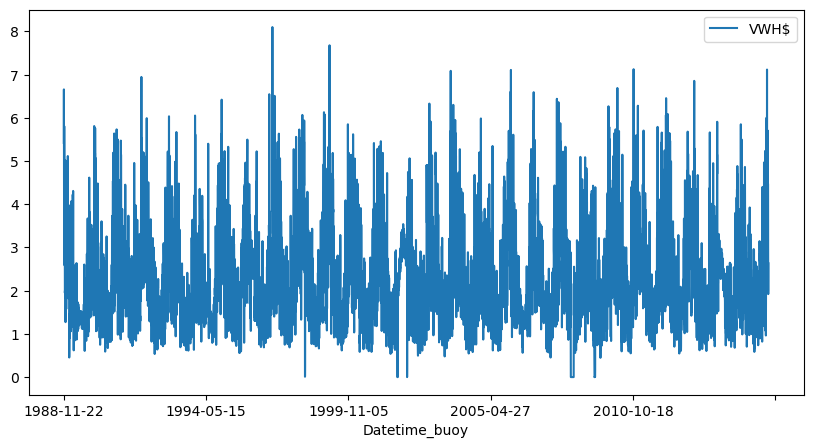

In [28]:
wave_height_data.plot(figsize=(10,5))

## Wave Height Time Series 

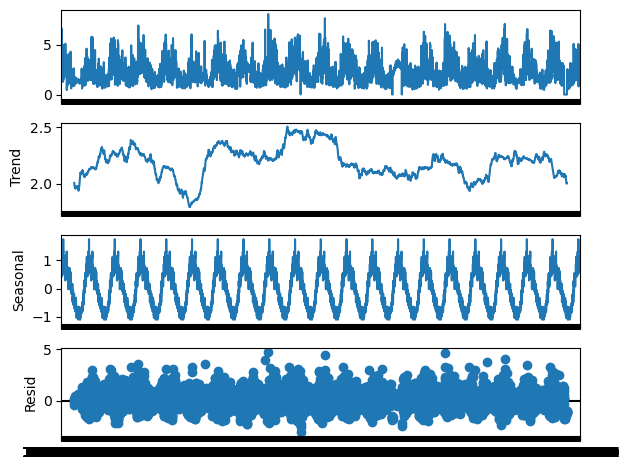

In [9]:
#decompose
result_decomp = seasonal_decompose(wave_height_data, period=365)
result_decomp.plot() #will show entire time range of data set
plt.show()

In [85]:
#Adfuller test function
def adfuller_test(wave_data):
    result = adfuller(wave_data)
    labels = ['ADF Test Statistic','p-val', '#Lags Used','Number of Observations Use']
    for value, label in zip(result,labels):
        print(label+':'+str(value))
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis(Ho), reject Ho. Data has no unit root')
    else:
        print('Weak evidence against the null hypothesis(Ho), time series has a unit root, indicating non stationarity.')


In [86]:
adfuller_test(wave_height_data['VWH$'])

ADF Test Statistic:-8.459714866331037
p-val:1.5793574166664836e-13
#Lags Used:28
Number of Observations Use:9873
Strong evidence against the null hypothesis(Ho), reject Ho. Data has no unit root


Appears that series is stationary according to ADF test. 

Appears that there are stable seasonal patterns that repeat. Use an Additive model. If using auto SARIMA from the pyramid library, this will find the optimal model, so addititive or multiplicative does not need to be specified.

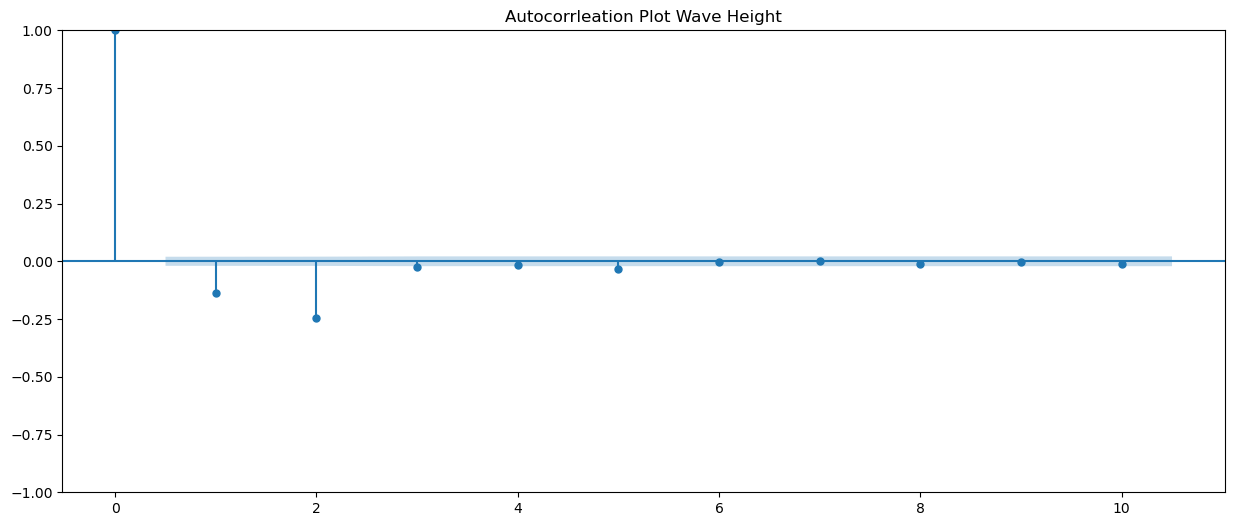

In [90]:
#Look at ACF plot 
lags= 10
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(wave_height_data.diff().dropna(),lags=lags,ax=ax) #differenced 
plt.title('Autocorrleation Plot Wave Height')
plt.show()

ACF plot shows spikes unti 3, q=2

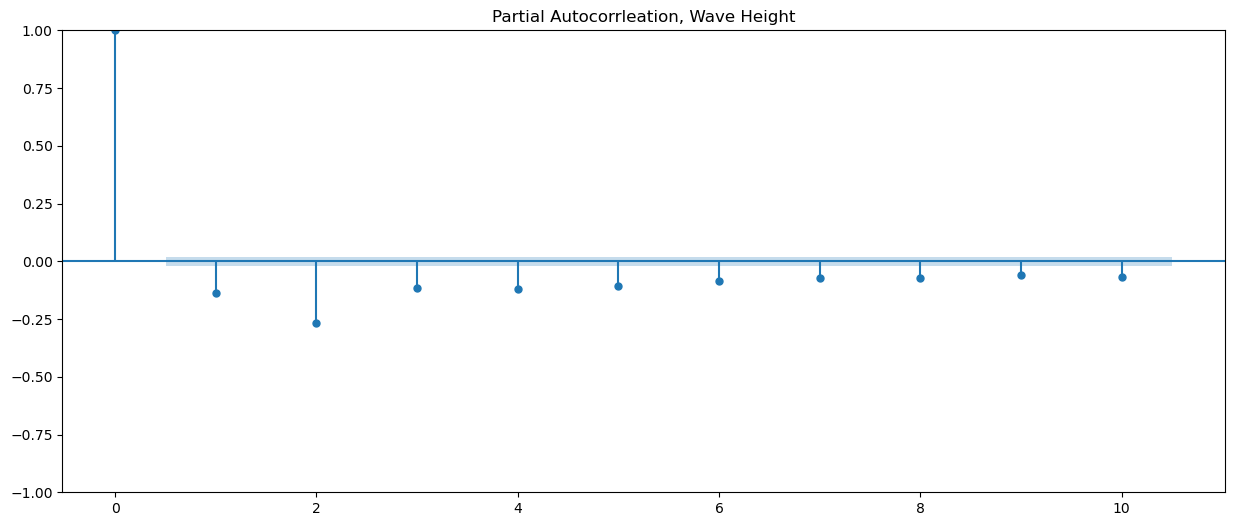

In [33]:
lags= 10
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(wave_height_data.diff().dropna(),lags=lags,ax=ax)
plt.title('Partial Autocorrleation, Wave Height')
plt.show()

PACF plot, stabalizes around 3, order(p) range 0-3

In [34]:
wave_height_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9902 entries, 1988-11-22 to 2016-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   VWH$    9902 non-null   float64
dtypes: float64(1)
memory usage: 154.7+ KB


In [17]:
wave_height_data.index = wave_height_data.index.astype('datetime64[ns]')

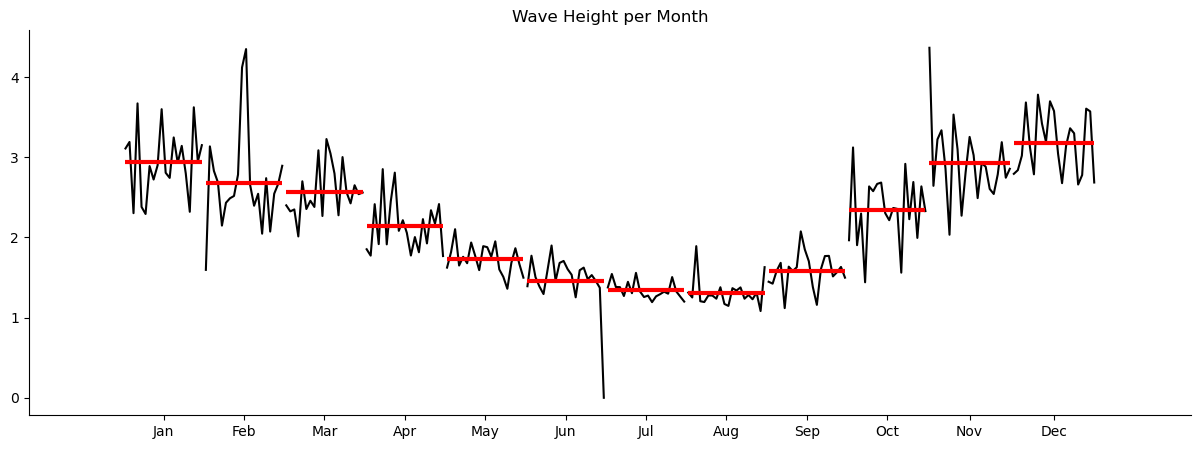

In [20]:
#create month plot of wave height
monthly_wh_data = wave_height_data['VWH$'].resample('M').mean()

plt.figure(figsize=(15, 5))

# create the seasonal plot
month_plot(monthly_wh_data, ax=plt.gca())

plt.title("Wave Height per Month")
sns.despine()
plt.show()

### ARIMA Wave Height

Split wave height to train and test set.

In [99]:
#train validate split on residuals for model optimization: 
split_point = '2006-01-01'
split_point_test = '2011-01-01'
train_wh = wave_height_data[wave_height_data.index < split_point]
val_wh = wave_height_data[(wave_height_data.index>= split_point) & (wave_height_data.index < split_point_test)]
test_wh = wave_height_data[wave_height_data.index >= split_point_test]

In [69]:
wave_height_data.index = pd.to_datetime(wave_height_data.index)


**Functions for Time Series**

In [44]:
#function to optimize arima with aic score
def optimize_arima_aic(train_data, p_range, d_values, q_range, trend_options):
    """
    Function to optimize ARIMA and return DataFrame with results.
    
    Params:
    - train_data: Time series data for training
    - p_range: Range of p values
    - d_values: List of d values
    - q_range: Range of q values
    - trend_options: List of trend options
    """
    # Generate all possible combinations of pdq and trend
    pdqt = list(itertools.product(p_range, d_values, q_range, trend_options))
    
    # Create an empty DataFrame to store results
    result_pdqt = pd.DataFrame(columns=['pdqt', 'AIC'])
    
    # Suppress convergence warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=ConvergenceWarning)
        
        # List of DataFrames to concatenate to results DataFrame
        dfs_to_concat = []
        
        # Iterate over all combinations
        for param in pdqt:
            try:
                order = param[:3]  # Extract pdq
                trend = param[3]   # Extract trend

                model_arima = sm.tsa.SARIMAX(train_data, order=order, trend=trend)
                result_i = pd.DataFrame({'pdqt': [param], 'AIC': [model_arima.fit(disp=False).aic]})
                dfs_to_concat.append(result_i)
            except Exception as e:
                print(f"Exception in iteration with param {param}: {e}")
                continue
        
        # Concatenate DataFrames from iterations to results DataFrame
        result_pdqt = pd.concat(dfs_to_concat, ignore_index=True)

    # Find the best parameters based on the lowest AIC score
    best_params = result_pdqt.loc[result_pdqt['AIC'].astype(float).idxmin()]['pdqt']
    
    # Fit the ARIMA model with the best parameters
    best_model = sm.tsa.SARIMAX(train_data, order=best_params[:3], trend=best_params[3])
    final_model = best_model.fit(disp=False)
    
    # Return both the results DataFrame and the best parameters
    return result_pdqt, best_params, final_model


In [73]:
def forecast_and_plot(model, wave_data, split_point, split_point_test, column_name='VWH$', is_validation=True):
    """
    Forecast on the validation or test set, create a plot with predictions,
    and calculate MSE and MAE for forecasted values.
    
    Params:
    - model: Fitted ARIMA model
    - wave_data: DataFrame with wave data
    - split_point: Date to split training and validation/test sets
    - split_point_test: Date to split validation and test sets
    - column_name: Column name for the wave data (default is 'VWH$')
    - is_validation: Flag indicating whether it's the validation set (default is True)
    
    Returns:
    - mse: Mean Squared Error
    - mae: Mean Absolute Error
    """
    # Exclude the validation/test set from the index when selecting the training set
    train_data = wave_data[wave_data.index < split_point]

    # Define the start and end dates based on whether it's the validation or test set
    if is_validation:
        start_eval = split_point
        end_eval = split_point_test
        title = 'True Values vs Predictions (Validation Set)'
    else:
        start_eval = split_point_test 
        end_eval = wave_data.index[-1]
        title = 'True Values vs Predictions (Test Set)'

    # Forecast on the validation or test set with a rolling window
    forecast = model.predict(start=start_eval, end=end_eval, dynamic=False)

    result_df = pd.DataFrame({'True Values': wave_data[(wave_data.index >= split_point) & (wave_data.index <= end_eval)][column_name].values,
                              'Predictions': forecast})

    # Plot true values and predictions for validation or test set using Plotly
    fig = px.line(result_df, x=result_df.index, y=['True Values', 'Predictions'],
                  labels={'value': 'Values', 'variable': 'Type'},
                  title=title,
                  template='plotly_dark')
    fig.show()

    # Calculate MSE and MAE for validation or test set
    mse = mean_squared_error(result_df['True Values'], result_df['Predictions'])
    mae = mean_absolute_error(result_df['True Values'], result_df['Predictions'])

    # Print the results
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Mean Absolute Error (MAE): {mae}')

    return mse, mae


In [79]:
def forecast_Rolling_plot(model, wave_data, split_point, split_point_test, window_size, is_validation=True, column_name='VWH$'):
    """
    Perform rolling forecasts on the validation or test set, create an interactive plot with Plotly,
    and calculate MSE and MAE for forecasted values.
    
    Parameters:
    - model: Fitted ARIMA model
    - wave_data: DataFrame containing wave data (height or period)
    - split_point: Date to split training and validation/test sets
    - split_point_test: Date to split validation and test sets
    - window_size: Size of the rolling window
    - is_validation: Flag indicating whether it's the validation set (default is True)
    - column_name: Name of the column to use for plotting (default is 'VWH$')
    
    Returns:
    - mse: Mean Squared Error
    - mae: Mean Absolute Error
    """
    
    # Exclude the validation/test set from the index when selecting the training set
    train_wave_data = wave_data[wave_data.index < split_point]
    
    if is_validation:
        eval_data = wave_data[wave_data.index >= split_point]
        title = 'True Values vs Predictions (Validation) - Rolling Window'
    else:
        eval_data = wave_data[wave_data.index >= split_point_test]
        title = 'True Values vs Predictions (Test) - Rolling Window'

    # Initialize lists to store forecasted values, MSE, and MAE
    forecast_values = []
    mse_list = []
    mae_list = []

    # Perform rolling forecasts
    for i in range(0, len(eval_data), window_size):
        start_idx = i  # define the current window, start and end are based on the window size
        end_idx = min(i + window_size - 1, len(eval_data) - 1)

        # Forecast on the current window
        forecast = model.predict(start=start_idx, end=end_idx, dynamic=False)

        # Append forecasted values to the list
        forecast_values.extend(forecast)

        # Calculate MSE and MAE for the current window
        mse = mean_squared_error(eval_data[start_idx:end_idx + 1], forecast)
        mae = mean_absolute_error(eval_data[start_idx:end_idx + 1], forecast)

        # Append MSE and MAE to the lists
        mse_list.append(mse)
        mae_list.append(mae)

    # Create an interactive plot with Plotly
    fig = go.Figure()

    # Add true values to the plot
    fig.add_trace(go.Scatter(x=eval_data.index, y=eval_data[column_name], mode='lines', name='True Values'))

    # Add predicted values to the plot
    fig.add_trace(go.Scatter(x=eval_data.index, y=forecast_values, mode='lines', name='Predictions'))

    # Customize the layout
    fig.update_layout(title=title,
                      xaxis_title='Date',
                      yaxis_title='Values',
                      showlegend=True)

    # Show the Plotly plot
    fig.show()

    # Calculate overall MSE and MAE for all forecasted values
    overall_mse = mean_squared_error(eval_data[column_name], forecast_values)
    overall_mae = mean_absolute_error(eval_data[column_name], forecast_values)

    # Print the overall results
    print(f'Overall Mean Squared Error (MSE): {overall_mse}')
    print(f'Overall Mean Absolute Error (MAE): {overall_mae}')

    return overall_mse, overall_mae


In [60]:
train_wh.index = pd.to_datetime(train_wh.index)
train_wh.index.freq = 'D'

In [64]:
#Optimize Arima for Wave Height
p_range = range(1,3)
d_values = [1]
q_range = range(0,2)
trend_options = ['c']

result, best_params, final_model=optimize_arima_aic(train_wh, p_range, d_values, q_range, trend_options)
print(f'Best ARIMA parameters: {best_params}')
print(result)

Best ARIMA parameters: (2, 1, 1, 'c')
           pdqt           AIC
0  (1, 1, 0, c)  13570.328890
1  (1, 1, 1, c)  12640.198128
2  (2, 1, 0, c)  13110.649836
3  (2, 1, 1, c)  12604.111990


                               SARIMAX Results                                
Dep. Variable:                   VWH$   No. Observations:                 6249
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -6297.056
Date:                Wed, 24 Jan 2024   AIC                          12604.112
Time:                        19:31:04   BIC                          12637.812
Sample:                    11-22-1988   HQIC                         12615.791
                         - 12-31-2005                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.835e-05      0.001     -0.051      0.959      -0.002       0.001
ar.L1          0.6154      0.011     54.022      0.000       0.593       0.638
ar.L2         -0.0845      0.011     -7.596      0.0

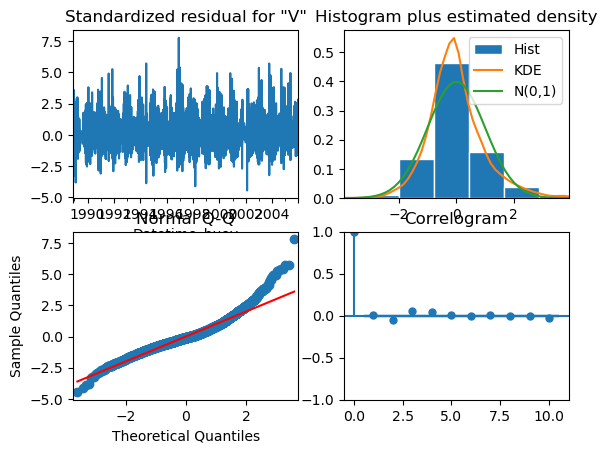

In [67]:
wh_model = final_model
results_model = final_model.summary()
print(results_model)
final_model.plot_diagnostics()
plt.show()

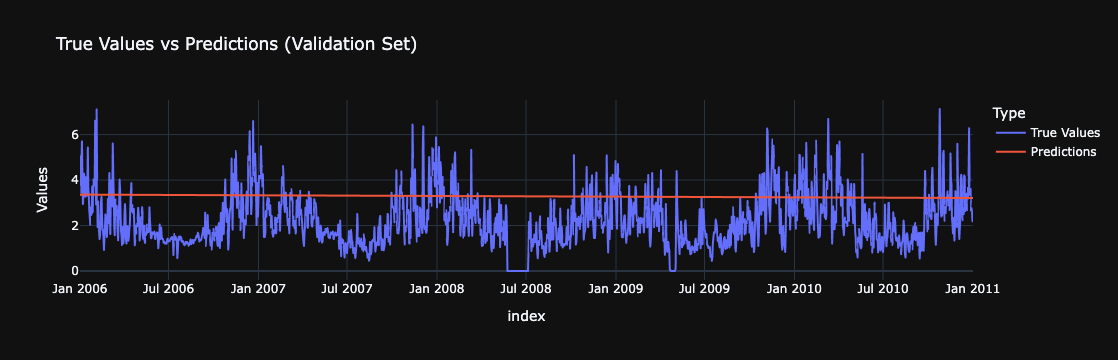

Mean Squared Error (MSE): 2.476048283461567
Mean Absolute Error (MAE): 1.3670716291939065


(2.476048283461567, 1.3670716291939065)

In [74]:
forecast_and_plot(wh_model, wave_height_data, split_point, split_point_test, column_name='VWH$', is_validation=True)

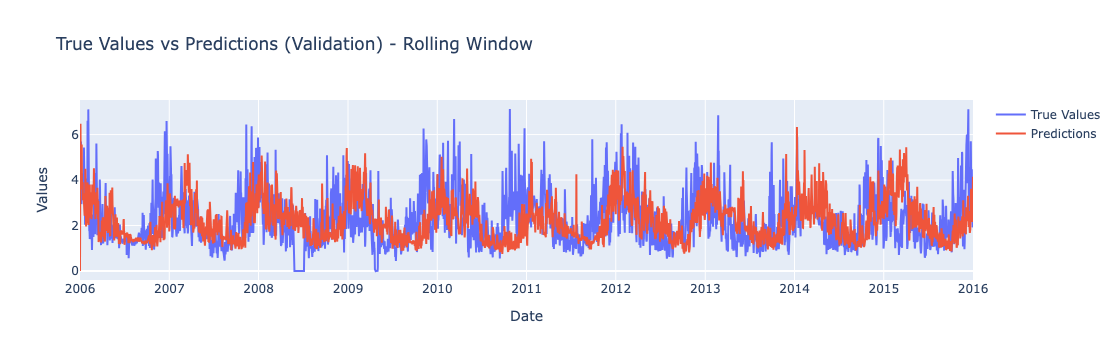

Overall Mean Squared Error (MSE): 1.4765367274552827
Overall Mean Absolute Error (MAE): 0.9137437361626162


In [81]:
#### FIX FUNCTION FOR VALIDATION AND TEST SPLIT
window_size =1
mse, mae =forecast_Rolling_plot(wh_model, wave_height_data, split_point, split_point_test, window_size, is_validation=True, column_name='VWH$')

**COME BACK AND TRY SARIMA**

## Wave Period Time Series

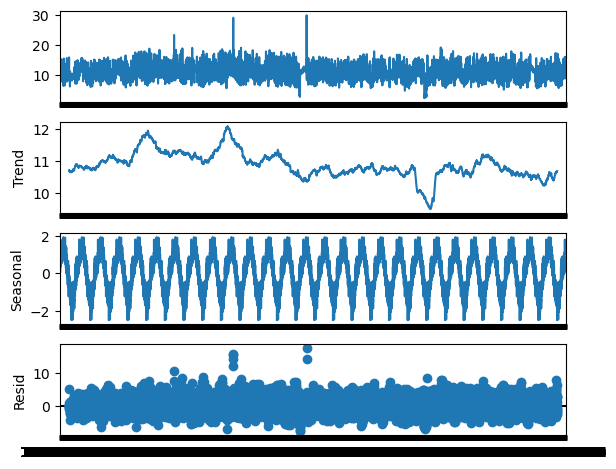

In [82]:
#decompose
result_decomp = seasonal_decompose(wave_period_data, period=365)
result_decomp.plot() #will show entire time range of data set
plt.show()

In [87]:
adfuller_test(wave_period_data['VTP$'])

ADF Test Statistic:-8.344663795179114
p-val:3.1086885108799965e-13
#Lags Used:37
Number of Observations Use:9864
Strong evidence against the null hypothesis(Ho), reject Ho. Data has no unit root


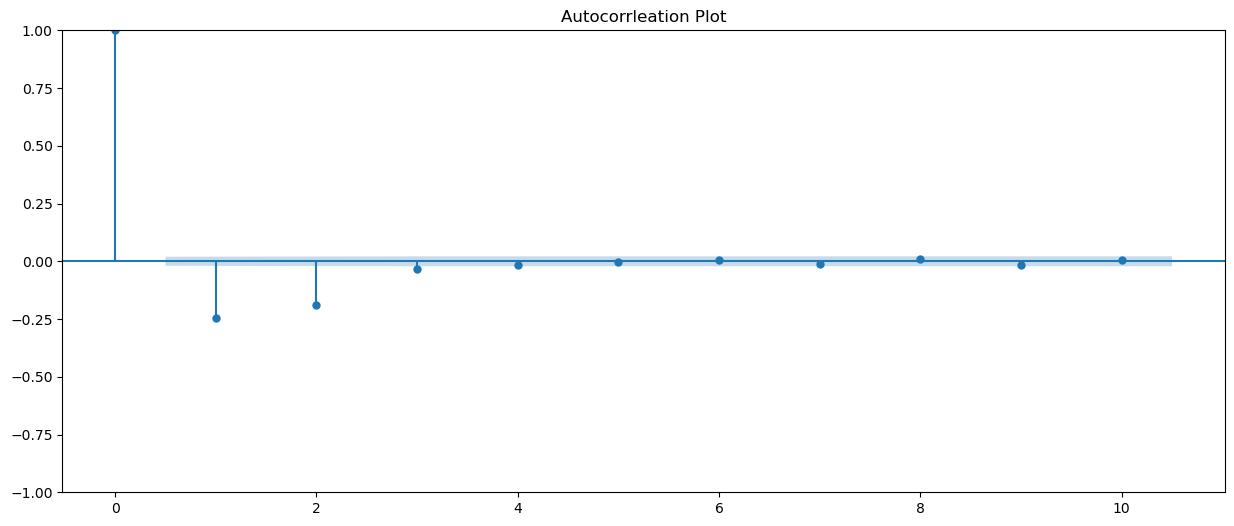

In [89]:
#Look at ACF plot 
lags= 10
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(wave_period_data.diff().dropna(),lags=lags,ax=ax) #differenced 
plt.title('Autocorrleation Plot')
plt.show()

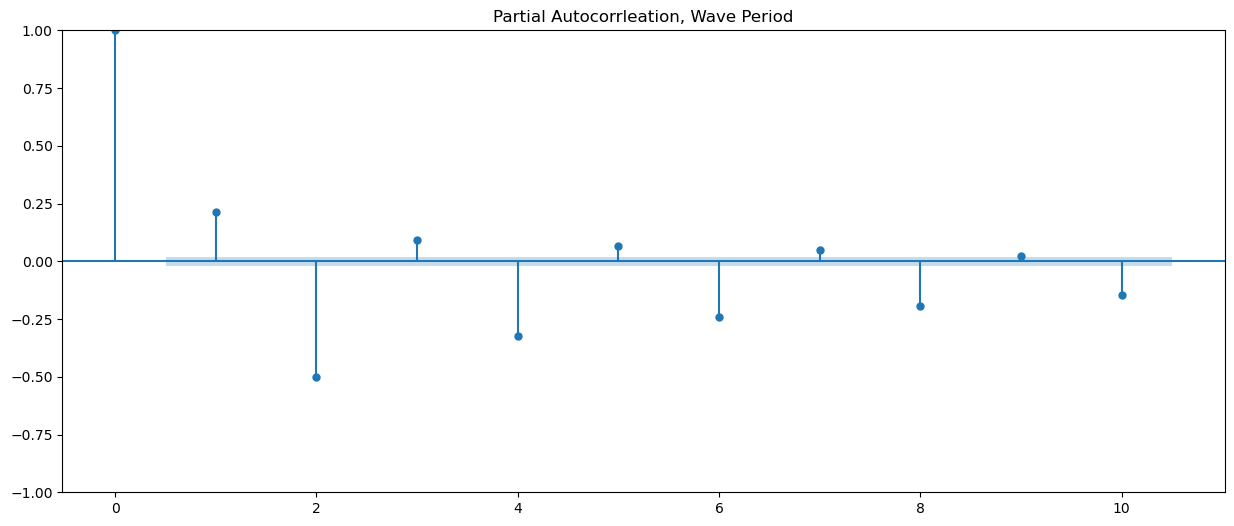

In [92]:
lags= 10
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(wave_period_data.diff(2).dropna(),lags=lags,ax=ax)
plt.title('Partial Autocorrleation, Wave Period')
plt.show()

In [94]:
wave_period_data.index = pd.to_datetime(wave_period_data.index)

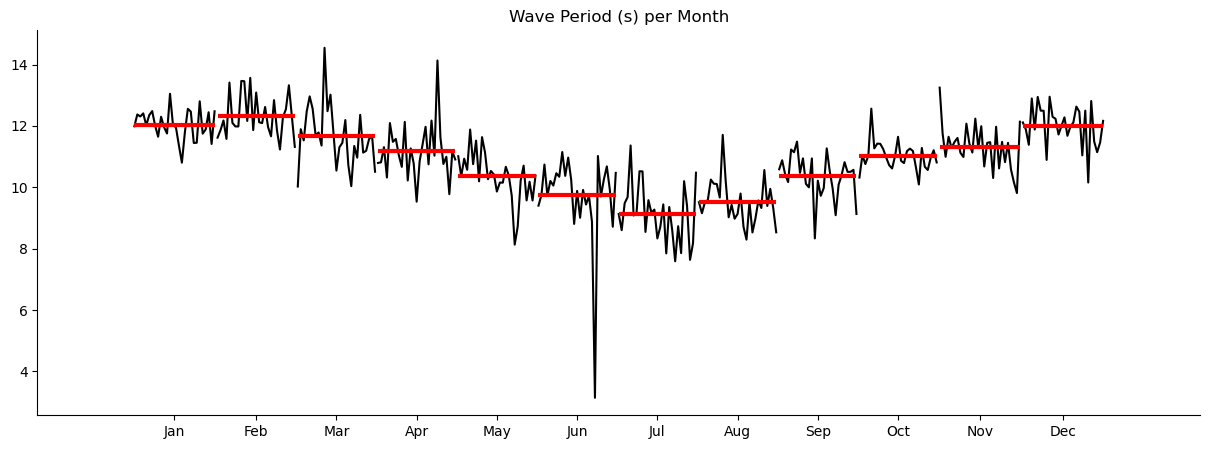

In [96]:
#create month plot of wave height
monthly_wp_data = wave_period_data['VTP$'].resample('M').mean()

plt.figure(figsize=(15, 5))

# create the seasonal plot
month_plot(monthly_wp_data, ax=plt.gca())

plt.title("Wave Period (s) per Month")
sns.despine()
plt.show()

### ARIMA Wave Period

In [98]:
#train validate split on residuals for model optimization: 
split_point = '2006-01-01'
split_point_test = '2011-01-01'
train_wp = wave_period_data[wave_period_data.index < split_point]
val_wp = wave_period_data[(wave_period_data.index>= split_point) & (wave_period_data.index < split_point_test)]
test_wp = wave_period_data[wave_period_data.index >= split_point_test]

In [103]:
train_wp.index = pd.to_datetime(train_wh.index)
train_wp.index.freq = 'D'

In [104]:
#Optimize Arima for Wave Height
p_range = range(1,3)
d_values = range(1,2)
q_range = range(0,3)
trend_options = ['c']

result, best_params, final_model=optimize_arima_aic(train_wp, p_range, d_values, q_range, trend_options)
print(f'Best ARIMA parameters: {best_params}')
print(result)

Best ARIMA parameters: (1, 1, 2, 'c')
           pdqt           AIC
0  (1, 1, 0, c)  26992.448817
1  (1, 1, 1, c)  25583.346368
2  (1, 1, 2, c)  25566.574387
3  (2, 1, 0, c)  26573.606172
4  (2, 1, 1, c)  25568.147618
5  (2, 1, 2, c)  25567.391899


                               SARIMAX Results                                
Dep. Variable:                   VTP$   No. Observations:                 6249
Model:               SARIMAX(1, 1, 2)   Log Likelihood              -12778.287
Date:                Wed, 24 Jan 2024   AIC                          25566.574
Time:                        20:29:25   BIC                          25600.274
Sample:                    11-22-1988   HQIC                         25578.254
                         - 12-31-2005                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -5.17e-05      0.001     -0.036      0.971      -0.003       0.003
ar.L1          0.3165      0.025     12.779      0.000       0.268       0.365
ma.L1         -0.8137      0.027    -30.117      0.0

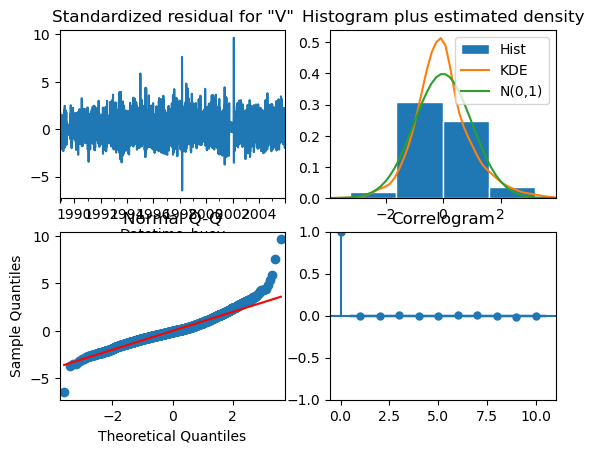

In [105]:
wp_model = final_model
results_model = wp_model.summary()
print(results_model)
wp_model.plot_diagnostics()
plt.show()

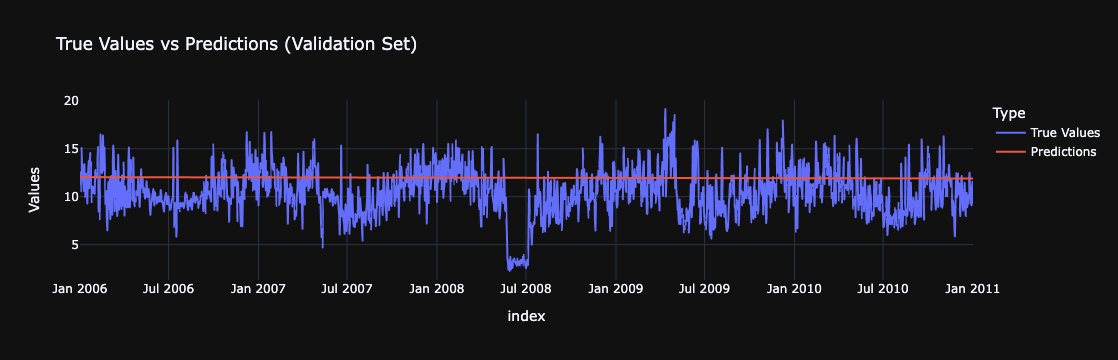

Mean Squared Error (MSE): 8.30028443529542
Mean Absolute Error (MAE): 2.281335164906199


(8.30028443529542, 2.281335164906199)

In [106]:
forecast_and_plot(wp_model, wave_period_data, split_point, split_point_test, column_name='VTP$', is_validation=True)

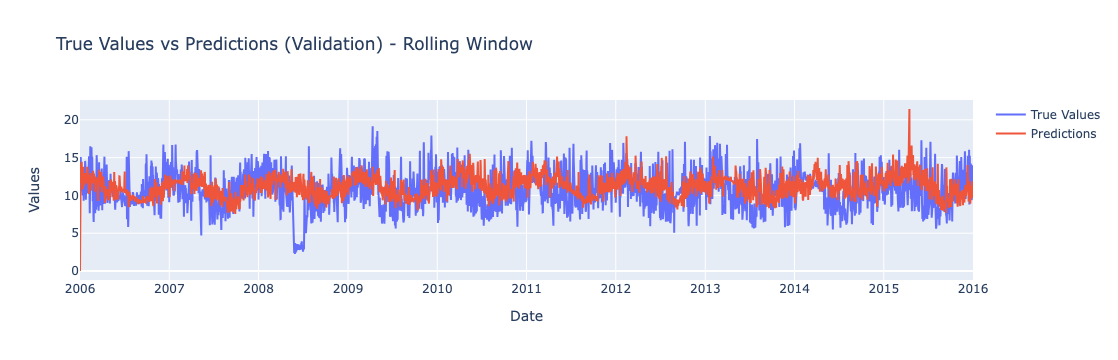

Overall Mean Squared Error (MSE): 6.949078304090905
Overall Mean Absolute Error (MAE): 2.0633793719182045


In [108]:
window_size =1
mse, mae =forecast_Rolling_plot(wp_model, wave_period_data, split_point, split_point_test, window_size, is_validation=True, column_name='VTP$')

# Create New DataFrame for Supervised Machine Learning

In [ ]:
def series_to_supervised(data, target_col, n_in=1, n_out=1, dropnan=True):
    df = DataFrame(data)
    cols = list()

    # Lag features including the target variable
    for col in df.columns:
        for i in range(n_in, 0, -1):
            cols.append(df[col].shift(i))
    
    # Lag the target variable for forecasting
    for i in range(0, n_out):
        cols.append(df[target_col].shift(-i))
    
    # Concatenate lagged features and target variable
    agg = concat(cols, axis=1)
    
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg.values

In [112]:
# convert directions(degrees North) into radians
columns_to_convert = ['VMD', 'VMDSea', 'VMDSw', 'WD', 'WDIR', 'WDIR.1']

# Convert specified columns to radians
df[columns_to_convert] = np.radians(df[columns_to_convert])